# Notebook 04: Consolidación y Análisis Exploratorio (EDA)

**Objetivo:** Crear el *Master Table* (Dataset de Entrenamiento) uniendo las tres fuentes de datos procesadas. Realizar ingeniería de características climáticas avanzadas y un análisis visual de las relaciones clave.

**Mejoras Implementadas:**
1. **Ingeniería Climática:** Cálculo de **Grados-Día** (HDD y CDD) para capturar la intensidad del frío y calor antes de agregar mensualmente.
2. **Limpieza Estructural:** Eliminación de columnas redundantes o vacías (como `nombre_comuna` del socioeconómico) para evitar ruido.
3. **EDA Estratégico:** Visualización enfocada en correlaciones, estacionalidad y desigualdad socioeconómica.

**Output:** `data/processed/master_table.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- RUTAS ---
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
FILE_ENERGIA = os.path.join(PROCESSED_DIR, 'consumo_electrico_limpio.csv')
FILE_CLIMA = os.path.join(PROCESSED_DIR, 'clima_diario_limpio.csv')
FILE_SOCIO = os.path.join(PROCESSED_DIR, 'socioeconomico_anual_completo.csv')
OUTPUT_FILE = os.path.join(PROCESSED_DIR, 'master_table.csv')

## 1. Carga de Datos Procesados

In [2]:
# 1. Energía
print(">>> Cargando Energía...")
df_energia = pd.read_csv(FILE_ENERGIA)
df_energia['fecha'] = pd.to_datetime(df_energia['fecha'])

# 2. Clima (Diario)
print(">>> Cargando Clima...")
df_clima = pd.read_csv(FILE_CLIMA)
df_clima['fecha'] = pd.to_datetime(df_clima['fecha'])

# 3. Socioeconómico
print(">>> Cargando Socioeconómico...")
df_socio = pd.read_csv(FILE_SOCIO)

print(f"  Registros Energía: {len(df_energia)}")
print(f"  Días Clima: {len(df_clima)}")

>>> Cargando Energía...
>>> Cargando Clima...
>>> Cargando Socioeconómico...
  Registros Energía: 74177
  Días Clima: 3940


## 2. Ingeniería de Features Climática (Grados-Día)
Para no perder información al promediar el mes, calculamos primero los **Grados-Día** a nivel diario:
* **HDD (Heating Degree Days):** Intensidad de frío (demanda de calefacción). Base 15°C.
* **CDD (Cooling Degree Days):** Intensidad de calor (demanda de aire acondicionado). Base 24°C.

In [3]:
print(">>> Calculando métricas climáticas avanzadas...")

# Cálculo diario
df_clima['HDD'] = (15 - df_clima['temp_prom']).clip(lower=0)
df_clima['CDD'] = (df_clima['temp_prom'] - 24).clip(lower=0)

# Agregación Mensual (Resampling)
df_clima.set_index('fecha', inplace=True)

df_clima_mensual = df_clima.resample('MS').agg(
    temp_prom_mes=('temp_prom', 'mean'),
    temp_max_abs=('temp_max', 'max'),
    temp_min_abs=('temp_min', 'min'),
    hdd_acumulado=('HDD', 'sum'),  # Suma total de frío del mes
    cdd_acumulado=('CDD', 'sum')   # Suma total de calor del mes
).reset_index()

print("Clima mensual generado (Primeras 3 filas):")
display(df_clima_mensual.head(3))

>>> Calculando métricas climáticas avanzadas...
Clima mensual generado (Primeras 3 filas):


,fecha,temp_prom_mes,temp_max_abs,temp_min_abs,hdd_acumulado,cdd_acumulado
0,2015-01-01,22.260000,35.2,12.4,0.0,1.40
1,2015-02-01,21.394643,35.2,10.2,0.0,3.42
2,2015-03-01,20.988710,35.5,10.6,0.0,0.52


## 3. Fusión (Merge) y Limpieza Final
Unimos las 3 fuentes y limpiamos columnas redundantes.

In [4]:
print(">>> Ejecutando Merge...")

# A) Energía + Clima (Cruce por Fecha)
df_master = pd.merge(df_energia, df_clima_mensual, on='fecha', how='left')

# B) Energía + Socio (Cruce por Comuna y Año)
# Limpieza preventiva: Eliminar nombre_comuna de socio si existe para evitar duplicados/nulos
if 'nombre_comuna' in df_socio.columns:
    df_socio = df_socio.drop(columns=['nombre_comuna'])

df_master = pd.merge(df_master, df_socio, on=['comuna_norm', 'anio'], how='left')

# C) Imputación de Nulos Climáticos (Si faltó algún mes, usar el anterior)
cols_clima = ['temp_prom_mes', 'temp_max_abs', 'temp_min_abs', 'hdd_acumulado', 'cdd_acumulado']
df_master[cols_clima] = df_master[cols_clima].ffill().bfill()

# D) Creación de Quintiles de Ingreso (Feature para análisis)
df_master['quintil'] = pd.qcut(df_master['ingreso_promedio'], 5, labels=['Q1 (Pobre)', 'Q2', 'Q3', 'Q4', 'Q5 (Rico)'])

print(f"Dimensiones finales: {df_master.shape}")
print(f"Nulos restantes:\n{df_master.isna().sum()}")

>>> Ejecutando Merge...
Dimensiones finales: (74177, 18)
Nulos restantes:
fecha                  0
anio                   0
mes                    0
comuna_norm            0
comuna                 0
region                 0
tipo_clientes          0
tarifa                 0
clientes_facturados    0
energia_kwh            0
temp_prom_mes          0
temp_max_abs           0
temp_min_abs           0
hdd_acumulado          0
cdd_acumulado          0
ingreso_promedio       0
tasa_pobreza           0
quintil                0
dtype: int64


## 4. Exportación

In [5]:
# Selección final de columnas limpias
cols_finales = [
    'fecha', 'anio', 'mes', 
    'region', 'comuna', 'comuna_norm',
    'tipo_clientes', 'tarifa', 
    'clientes_facturados', 'energia_kwh', 
    'temp_prom_mes', 'temp_max_abs', 'temp_min_abs', 'hdd_acumulado', 'cdd_acumulado',
    'ingreso_promedio', 'tasa_pobreza', 'quintil'
]

df_master = df_master[cols_finales]
df_master.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Master Table guardada en: {OUTPUT_FILE}")

✅ Master Table guardada en: ..\data\processed\master_table.csv


## 5. Análisis Exploratorio (EDA)

In [6]:
# Mostramos las primeras filas del dataframe final
display(df_master)

,fecha,anio,mes,region,comuna,comuna_norm,tipo_clientes,tarifa,clientes_facturados,energia_kwh,temp_prom_mes,temp_max_abs,temp_min_abs,hdd_acumulado,cdd_acumulado,ingreso_promedio,tasa_pobreza,quintil
0,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.1,1.0,1415,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
1,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PPP,55.0,198996,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
2,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PP,411.0,1635743,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
3,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.2,1.0,1915,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
4,2015-01-01,2015,1,Región Metropolitana de Santiago,María Pinto,maria pinto,No Residencial,AT2PP,1.0,3127,22.260000,35.2,12.4,0.00,1.40,338265.310606,0.058252,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74172,2024-12-01,2024,12,Región Metropolitana de Santiago,Recoleta,recoleta,No Residencial,BT4.3,560.0,2423450,20.360645,35.0,7.8,0.36,1.55,335648.077493,0.045014,Q3
74173,2024-12-01,2024,12,Región Metropolitana de Santiago,San Ramón,san ramon,No Residencial,BT4.3,109.0,261068,20.360645,35.0,7.8,0.36,1.55,291766.365507,0.057488,Q2
74174,2024-12-01,2024,12,Región Metropolitana de Santiago,Lo Espejo,lo espejo,No Residencial,BT4.3,166.0,544728,20.360645,35.0,7.8,0.36,1.55,249684.350394,0.049494,Q1 (Pobre)
74175,2024-12-01,2024,12,Región Metropolitana de Santiago,La Reina,la reina,No Residencial,BT4.3,270.0,1059619,20.360645,35.0,7.8,0.36,1.55,870546.789924,0.016160,Q5 (Rico)


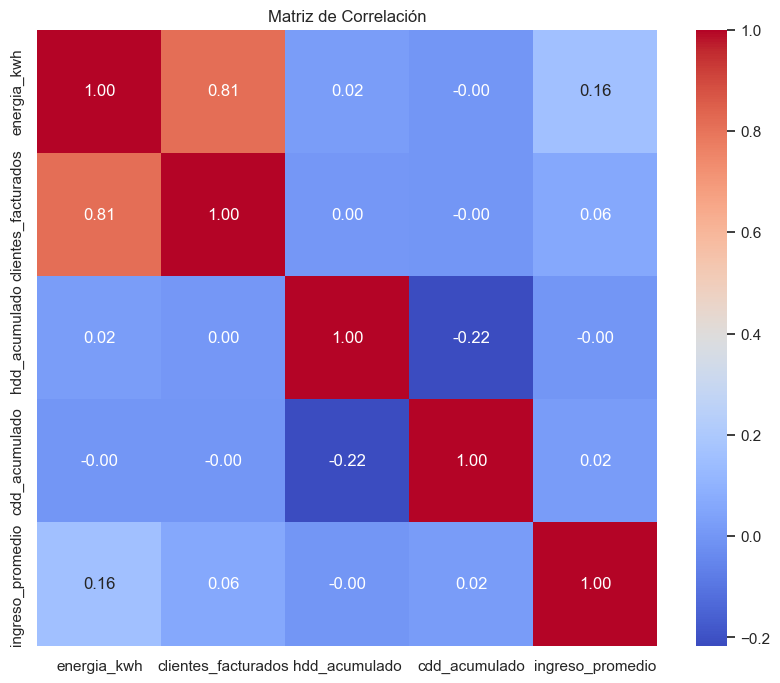

In [7]:
# 5.1 Correlaciones
plt.figure(figsize=(10, 8))
cols_num = ['energia_kwh', 'clientes_facturados', 'hdd_acumulado', 'cdd_acumulado', 'ingreso_promedio']
sns.heatmap(df_master[cols_num].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

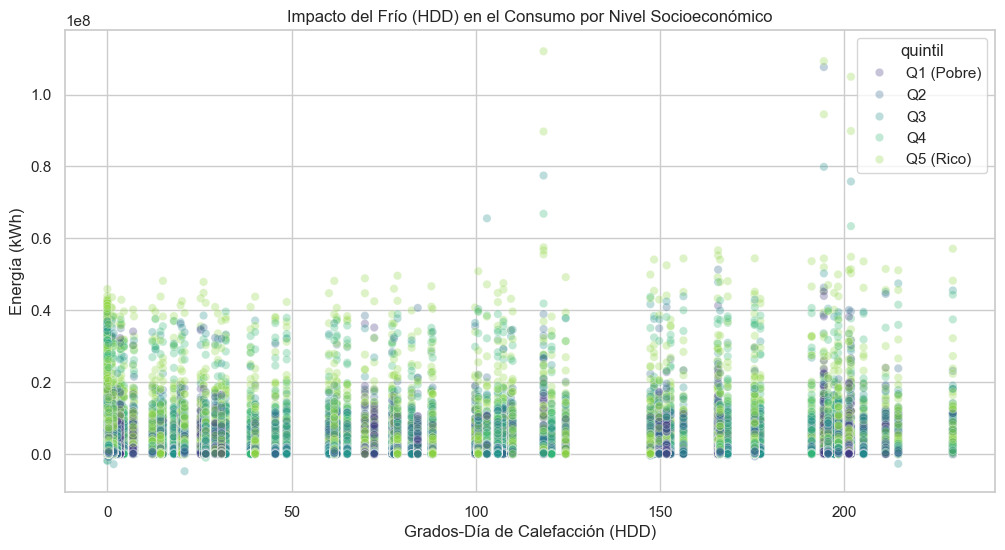

In [8]:
# 5.2 Consumo vs Frío (HDD)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_master, x='hdd_acumulado', y='energia_kwh', hue='quintil', alpha=0.3, palette='viridis')
plt.title("Impacto del Frío (HDD) en el Consumo por Nivel Socioeconómico")
plt.xlabel("Grados-Día de Calefacción (HDD)")
plt.ylabel("Energía (kWh)")
plt.show()

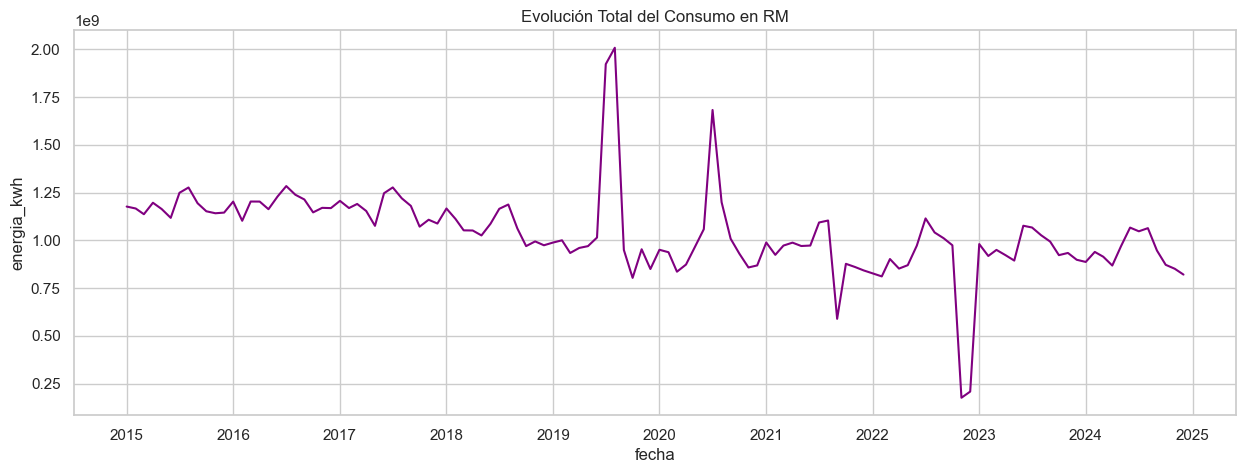

In [9]:
# 5.3 Serie Temporal Agregada
df_ts = df_master.groupby('fecha')['energia_kwh'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_ts, x='fecha', y='energia_kwh', color='purple')
plt.title("Evolución Total del Consumo en RM")
plt.show()